In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/camera-photos-vs-ai-generated-photos-classifier/ai vs real photos/Ai_Images/Image_22.jpg
/kaggle/input/camera-photos-vs-ai-generated-photos-classifier/ai vs real photos/Ai_Images/45.jpg
/kaggle/input/camera-photos-vs-ai-generated-photos-classifier/ai vs real photos/Ai_Images/56.jpg
/kaggle/input/camera-photos-vs-ai-generated-photos-classifier/ai vs real photos/Ai_Images/89.jpg
/kaggle/input/camera-photos-vs-ai-generated-photos-classifier/ai vs real photos/Ai_Images/58.jpg
/kaggle/input/camera-photos-vs-ai-generated-photos-classifier/ai vs real photos/Ai_Images/150.jpg
/kaggle/input/camera-photos-vs-ai-generated-photos-classifier/ai vs real photos/Ai_Images/109.jpg
/kaggle/input/camera-photos-vs-ai-generated-photos-classifier/ai vs real photos/Ai_Images/149.jpg
/kaggle/input/camera-photos-vs-ai-generated-photos-classifier/ai vs real photos/Ai_Images/187.jpg
/kaggle/input/camera-photos-vs-ai-generated-photos-classifier/ai vs real photos/Ai_Images/76.jpg
/kaggle/input/camera

# Table of Contents

- [Imports & Downloads](#imports-downloads)
- [Configuration](#configuration)
- [Sample Images](#sample)
- [Image Preparation](#preparation)
- [Model](#model)
- [Predict Unseen Images](#predict)

<a id="imports-downloads"></a>
# Imports & Downloads

In [2]:
import random

# visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# image preparation and model creation
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, GlobalMaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop

# download image from the internet
import urllib.request

In [3]:
# download pre-trained weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /kaggle/working/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2024-12-06 04:08:31--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.179.155, 142.250.179.219, 142.250.179.187, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.179.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: '/kaggle/working/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

/kaggle/working/inc 100%[===================>]  83.84M  30.5MB/s    in 2.8s    

2024-12-06 04:08:34 (30.5 MB/s) - '/kaggle/working/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5' saved [87910968/87910968]



<a id="configuration"></a>
# Configuration

In [4]:
IMAGE_BASE_PATH = '/kaggle/input/camera-photos-vs-ai-generated-photos-classifier/ai vs real photos/'
AI_FOLDER = 'Ai_Images'
CAMERA_FOLDER = 'Camera_images'
MODEL_PATH = '/kaggle/working/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
UNSEEN_IMAGE_AI = 'https://cdn.pixabay.com/photo/2022/10/28/09/02/woman-7552669_1280.jpg'
UNSEEN_IMAGE_AI_FILENAME = 'ai.jpg'
UNSEEN_IMAGE_CAMERA = 'https://cdn.pixabay.com/photo/2016/10/29/03/10/sky-1779798_1280.jpg'
UNSEEN_IMAGE_CAMERA_FILENAME = 'camera.jpg'

In [5]:
CLASS_NAMES = [AI_FOLDER, CAMERA_FOLDER]

<a id="sample"></a>
# Sample Images

randomly display an image from each class.

In [6]:
def random_img(base_folder, class_folder):
    folder = f'{base_folder}/{class_folder}'
    random_image = random.sample(os.listdir(folder), 1)
    img = mpimg.imread(f'{folder}/{random_image[0]}')

    return img

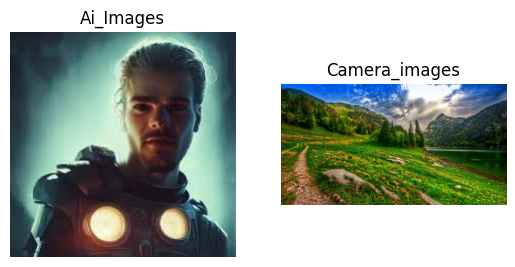

In [7]:
plt.figure()

for index, item in enumerate(CLASS_NAMES):
    plt.subplot(1, 2, index + 1)
    plt.title(item)
    img = random_img(IMAGE_BASE_PATH, item)
    plt.imshow(img)
    plt.axis('off');

<a id="preparation"></a>
# Image Preparation

In [8]:
# configure data augmentation
train_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

# generate batch of augmented data
train_generator = train_datagen.flow_from_directory(
    IMAGE_BASE_PATH,
    batch_size = 10,
    class_mode = 'binary',
    target_size = (150, 150)
)

Found 454 images belonging to 2 classes.


<a id="model"></a>
# Model

In [9]:
# initialize the base model, setting input shape and remove dense layers
pre_trained_model = InceptionV3(
    input_shape = (150, 150, 3),
    include_top = False,
    weights = None
)

# load the pre-trained weights.
pre_trained_model.load_weights(MODEL_PATH)

# freeze the weights of the layers
for layer in pre_trained_model.layers:
  layer.trainable = False

# display model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalizati

In [10]:
# use 'mixed7' as the last layer of the base model
last_layer = pre_trained_model.get_layer('mixed7')

# configure dense layers
x = GlobalMaxPooling2D()(last_layer.output)
x = Dense(1024, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1, activation = 'sigmoid')(x)

# append the dense layers to the base model
model = Model(pre_trained_model.input, x)

# display model summery (dense is added after 'mixed7' layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalization[0][0

In [11]:
# set the training parameters
model.compile(
    optimizer = RMSprop(learning_rate = 0.0001),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [12]:
# train the model
history = model.fit(
    train_generator,
    steps_per_epoch = 10,
    epochs = 20,
    verbose = 2
)

Epoch 1/20
10/10 - 9s - loss: 0.9788 - accuracy: 0.4500 - 9s/epoch - 869ms/step
Epoch 2/20
10/10 - 4s - loss: 0.7433 - accuracy: 0.6500 - 4s/epoch - 438ms/step
Epoch 3/20
10/10 - 4s - loss: 0.6668 - accuracy: 0.6596 - 4s/epoch - 429ms/step
Epoch 4/20
10/10 - 4s - loss: 0.7006 - accuracy: 0.6702 - 4s/epoch - 399ms/step
Epoch 5/20
10/10 - 4s - loss: 0.6729 - accuracy: 0.7000 - 4s/epoch - 366ms/step
Epoch 6/20
10/10 - 4s - loss: 0.7774 - accuracy: 0.6500 - 4s/epoch - 440ms/step
Epoch 7/20
10/10 - 3s - loss: 0.7549 - accuracy: 0.6277 - 3s/epoch - 344ms/step
Epoch 8/20
10/10 - 4s - loss: 0.8978 - accuracy: 0.6100 - 4s/epoch - 442ms/step
Epoch 9/20
10/10 - 4s - loss: 0.6333 - accuracy: 0.7100 - 4s/epoch - 417ms/step
Epoch 10/20
10/10 - 4s - loss: 0.5292 - accuracy: 0.7553 - 4s/epoch - 378ms/step
Epoch 11/20
10/10 - 4s - loss: 0.4622 - accuracy: 0.7900 - 4s/epoch - 432ms/step
Epoch 12/20
10/10 - 4s - loss: 0.5844 - accuracy: 0.7000 - 4s/epoch - 386ms/step
Epoch 13/20
10/10 - 4s - loss: 0.4393

<a id="predict"></a>
# Predict Unseen Images

In [13]:
def download_img(url, filename):
    opener = urllib.request.build_opener()
    opener.addheaders = [('User-Agent', 'whatever')]
    urllib.request.install_opener(opener)
    urllib.request.urlretrieve(url, filename)

In [14]:
# read and transform image to match model's input
def load_img(filename):
    img = tf.io.read_file(filename)
    img = tf.image.decode_image(img, channels = 3)
    img = tf.image.resize(img, size = [150, 150])
    img = img / 255.

    return img

In [15]:
def pred_and_plot(filename):
    img = load_img(filename)
    pred = model.predict(tf.expand_dims(img, axis = 0))
    pred_class = CLASS_NAMES[int(tf.round(pred)[0][0])]
    
    plt.imshow(img)
    plt.title(f'Prediction: {pred_class}')
    plt.axis(False)

1/1 [==============================] - 1s 1s/step


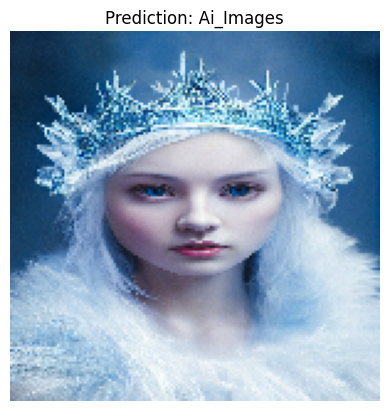

In [16]:
download_img(UNSEEN_IMAGE_AI, UNSEEN_IMAGE_AI_FILENAME)
pred_and_plot(UNSEEN_IMAGE_AI_FILENAME)

1/1 [==============================] - 0s 48ms/step


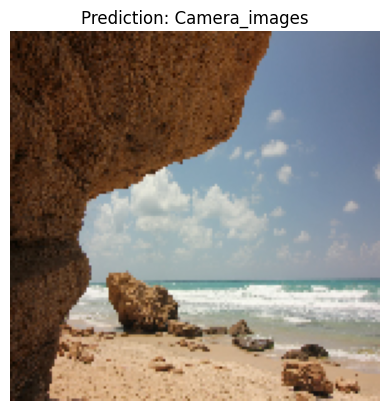

In [17]:
download_img(UNSEEN_IMAGE_CAMERA, UNSEEN_IMAGE_CAMERA_FILENAME)
pred_and_plot(UNSEEN_IMAGE_CAMERA_FILENAME)

In [18]:
model.save('/kaggle/working/model.keras')
import joblib

# Save the model as a .pkl file
joblib.dump(model, '/kaggle/working/model.pkl')


['/kaggle/working/model.pkl']

In [19]:
import joblib

# Save the model as a .pkl file
joblib.dump(model, '/kaggle/working/model1.pkl')

# You can verify if the file is saved by listing the files in the working directory
import os
print(os.listdir('/kaggle/working/'))


['camera.jpg', '__notebook__.ipynb', 'model.pkl', 'model.keras', 'ai.jpg', 'model1.pkl', 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5']
